In [2]:

import pandas_datareader as pdr
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Collecting Data

In [3]:
# df = pdr.get_data_tiingo('MRO', api_key=key)
# df.to_csv('MRO.csv')

In [4]:
df = pd.read_csv('MRO.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MRO,2017-05-31 00:00:00+00:00,13.02,13.10,12.75,12.92,14540830,12.211546,12.286579,11.958311,12.117756,14540830,0.0,1.0
1,MRO,2017-06-01 00:00:00+00:00,13.10,13.41,12.95,13.05,11547207,12.286579,12.577330,12.145893,12.239683,11547207,0.0,1.0
2,MRO,2017-06-02 00:00:00+00:00,12.72,12.99,12.56,12.96,13797001,11.930174,12.183409,11.780109,12.155272,13797001,0.0,1.0
3,MRO,2017-06-05 00:00:00+00:00,12.78,12.86,12.54,12.61,10988204,11.986449,12.061481,11.761351,11.827004,10988204,0.0,1.0
4,MRO,2017-06-06 00:00:00+00:00,12.88,12.96,12.64,12.76,10639213,12.080239,12.155272,11.855142,11.967690,10639213,0.0,1.0


In [5]:
df1 = df.reset_index()['close']
df1.shape

(1259,)

In [6]:
df1.head()

0    13.02
1    13.10
2    12.72
3    12.78
4    12.88
Name: close, dtype: float64

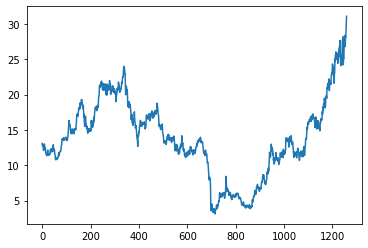

In [7]:
plt.plot(df1)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.35420394],
       [0.35706619],
       [0.34347048],
       ...,
       [0.92629696],
       [0.95277281],
       [1.        ]])

## Splitting Data for Training and Testing

In [9]:
train_size = int(len(df1)*0.65)
test_size = len(df1) - train_size
train_data, test_data = df1[0:train_size,:], df1[train_size:len(df1),:1]
len(train_data), len(test_data)

(818, 441)

## Preprocessing

In [10]:
def create_data_matrix(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_data_matrix(train_data, time_step)
X_test, y_valid = create_data_matrix(test_data, time_step)

In [12]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_train.shape)

(717, 100)
(717,)
(340, 100)
(717,)


(None, None)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Implementing Stacked LSTM Model

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, validation_data=(X_test, y_valid), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 7s 237ms/step - loss: 0.0536 - val_loss: 0.0184
Epoch 2/100
12/12 [==============================] - 2s 155ms/step - loss: 0.0096 - val_loss: 0.0045
Epoch 3/100
12/12 [==============================] - 2s 178ms/step - loss: 0.0049 - val_loss: 0.0066
Epoch 4/100
12/12 [==============================] - 2s 130ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 5/100
12/12 [==============================] - 2s 133ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/100
12/12 [==============================] - 2s 125ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/100
12/12 [==============================] - 2s 146ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 8/100
12/12 [==============================] - 2s 147ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 9/100
12/12 [==============================] - 2s 144ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/100
12/12 [==============================] - 2s 140ms/step - loss: 0.0018 - val_lo

## Predict Test Data

In [17]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 25ms/step


In [18]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

## Calculate RMSE and Plot Data

In [19]:
math.sqrt(mean_squared_error(y_train, train_predict))

14.653996821622258

In [20]:
math.sqrt(mean_squared_error(y_valid, test_predict))

16.124132745011682

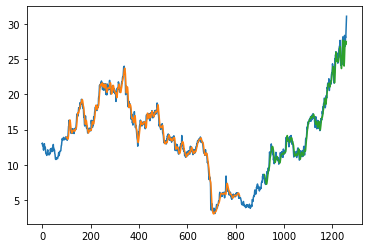

In [21]:
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+time_step*2 + 1: len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Predict Future Data

In [22]:
len(test_data)

441

In [23]:
x_input = test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [24]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [25]:
temp_input

[0.5041144901610018,
 0.5334525939177102,
 0.5409660107334525,
 0.523076923076923,
 0.5559928443649373,
 0.5577817531305903,
 0.552772808586762,
 0.5849731663685152,
 0.5835420393559928,
 0.5717352415026834,
 0.5567084078711986,
 0.5359570661896244,
 0.5431127012522361,
 0.586046511627907,
 0.5899821109123434,
 0.5985688729874776,
 0.598211091234347,
 0.5849731663685152,
 0.6271914132379248,
 0.6386404293381037,
 0.6339892665474061,
 0.657602862254025,
 0.6615384615384615,
 0.643649373881932,
 0.6586762075134168,
 0.6543828264758497,
 0.683005366726297,
 0.6472271914132379,
 0.6232558139534883,
 0.6422182468694096,
 0.6715563506261181,
 0.6708407871198568,
 0.661180679785331,
 0.6661896243291591,
 0.6550983899821109,
 0.6711985688729875,
 0.6955277280858675,
 0.7073345259391771,
 0.7112701252236135,
 0.7073345259391771,
 0.7402504472271914,
 0.758855098389982,
 0.7502683363148479,
 0.7255813953488371,
 0.7427549194991054,
 0.7173524150268337,
 0.6819320214669051,
 0.6629695885509839,
 

In [26]:
lst_output = []
n_steps = 100
i = 0
while(i<30):
    if (len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1,n_steps,1))
        y_hat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, y_hat))
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        y_hat = model.predict(x_input, verbose=0)
        print(y_hat[0])
        temp_input.extend(y_hat[0].tolist())
        print(len(temp_input))
        lst_output.extend(y_hat.tolist())
        i = i + 1
        
print(lst_output)

[0.9267231]
101
1 day input [0.53345259 0.54096601 0.52307692 0.55599284 0.55778175 0.55277281
 0.58497317 0.58354204 0.57173524 0.55670841 0.53595707 0.5431127
 0.58604651 0.58998211 0.59856887 0.59821109 0.58497317 0.62719141
 0.63864043 0.63398927 0.65760286 0.66153846 0.64364937 0.65867621
 0.65438283 0.68300537 0.64722719 0.62325581 0.64221825 0.67155635
 0.67084079 0.66118068 0.66618962 0.65509839 0.67119857 0.69552773
 0.70733453 0.71127013 0.70733453 0.74025045 0.7588551  0.75026834
 0.7255814  0.74275492 0.71735242 0.68193202 0.66296959 0.6608229
 0.7137746  0.71413238 0.78461538 0.7706619  0.80357782 0.80178891
 0.82003578 0.79320215 0.78282648 0.80071556 0.78676208 0.80966011
 0.80715564 0.77567084 0.76207513 0.780322   0.81502683 0.79069767
 0.82826476 0.83899821 0.84042934 0.85008945 0.84651163 0.87763864
 0.82182469 0.78282648 0.75205725 0.74991055 0.7706619  0.79928444
 0.77996422 0.78103757 0.82754919 0.87906977 0.87871199 0.89552773
 0.75420394 0.76100179 0.78890877 0.

In [27]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)
len(df1)

1259

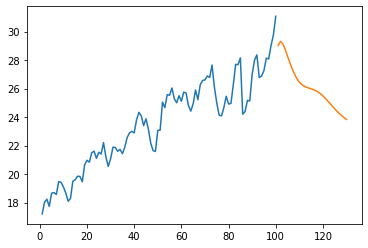

In [38]:
df3 = df1.tolist()
df3.extend(lst_output)

plt.plot(day_new, scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

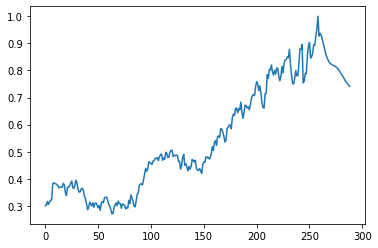

In [42]:
plt.plot(df3[1000:])

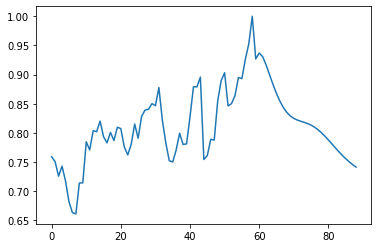

In [43]:
plt.plot(df3[1200:])